In [40]:
%matplotlib inline
from decimal import Decimal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, normaltest, norm
from scipy.stats import bootstrap
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import shutil
import random

rng = np.random.default_rng()
# A few helper functions:
#from utils import *

from statannot import add_stat_annotation
#from pandas.compat import StringIO

sns.set(style="whitegrid")

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

from statannotations.Annotator import Annotator

In [41]:
import matplotlib, matplotlib.cm
print("Matplotlib version:", matplotlib.__version__)
print("sns version:", sns.__version__)
print("matplotlib.cm coming from:", matplotlib.cm.__file__)

Matplotlib version: 3.10.3
sns version: 0.13.2
matplotlib.cm coming from: c:\Users\lliza\OneDrive\Desktop\cell_detection\venv\Lib\site-packages\matplotlib\cm.py


# pmArch3 HEK293T LED ON 2025-03-20

In [42]:
df_pmA3_TFEB = pd.read_excel('pmArch3-TFEB_Fiji.xlsx', sheet_name='20250320_res_assigned') #Nuc
df_pmA3_TFEB.head()

,Experiment,Cell,Nuc/cyto TFEB-GFP fluorescence
0,start,Cell1,0.537187
1,start,Cell2,0.664910
2,start,Cell3,0.619972
3,start,Cell4,0.871316
4,start,Cell5,0.832995


In [43]:
df_pmA3_TFEB.Experiment.drop_duplicates()

0             start
10       1h w/o LED
20         1h w LED
30    1.5h post-LED
40    2.5h post-LED
50      4h post-LED
60    5.5h post-LED
70      7h post-LED
80    8.5h post-LED
Name: Experiment, dtype: object

In [44]:
df_pmA3_TFEB_wide = df_pmA3_TFEB.pivot_table(index="Experiment", columns="Cell", values="Nuc/cyto TFEB-GFP fluorescence",sort=False)
df_pmA3_TFEB_wide

Cell,Cell1,Cell2,Cell3,Cell4,Cell5,Cell6,Cell7,Cell8,Cell9,Cell10
Experiment,,,,,,,,,,
start,0.537187,0.664910,0.619972,0.871316,0.832995,0.847163,1.263367,1.094628,0.653982,0.641657
1h w/o LED,0.502835,0.661876,0.640809,0.662153,0.883311,1.205101,1.812747,0.982679,1.313692,0.566001
1h w LED,1.378236,1.246876,1.160919,1.091396,2.381218,3.084541,2.420957,2.460185,3.871221,1.142178
1.5h post-LED,0.586980,0.751018,0.610119,0.594156,0.728915,1.130359,1.954218,1.499319,1.685325,0.837241
2.5h post-LED,0.609393,0.698957,0.737620,0.588243,0.742658,1.116096,1.996740,1.656774,1.569449,0.841991
4h post-LED,0.552434,0.749533,0.491038,0.509955,0.763134,1.270588,1.355567,1.529776,1.451853,0.573018
5.5h post-LED,0.508602,0.679803,0.465911,0.491692,0.744548,1.307095,1.618999,1.211070,1.296442,0.766606
7h post-LED,0.561470,0.554952,0.496112,0.528836,0.696646,1.143434,1.226831,1.471021,1.308010,0.718659
8.5h post-LED,0.456960,0.563525,0.523185,0.511635,0.658622,1.106464,1.114928,1.378873,1.581118,0.713911


<Axes: xlabel='Experiment'>

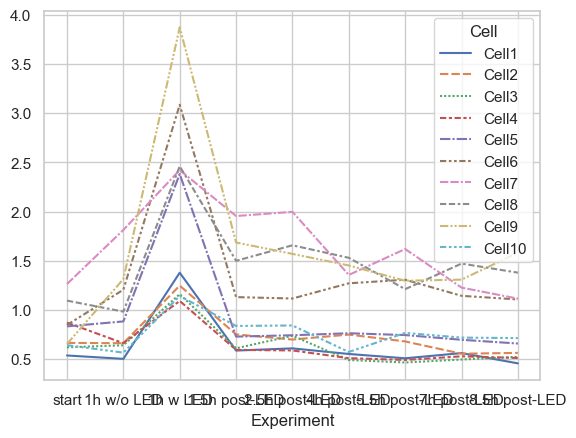

In [45]:
sns.lineplot(df_pmA3_TFEB_wide)

In [112]:
#for AO
def make_a_graph_with_order(data, y, x, title, stat_test):
    medians = data.groupby(by=[x], sort=False)[y].median() 
    std = data.groupby(by=[x], sort=False)[y].std() 
    
    my_order = medians.index
    palette = ['black']
    
    #Plot figure
    ###############################################################################################
    plt.figure(figsize=(20, 20))
    sns.set_context("paper", rc={"font.size":50,"axes.titlesize":50,"axes.labelsize":25})
    
    ###############################################################################################
    #draw dots
    bplot = sns.stripplot(y=y, x=x,  size=15,
                data=data, palette="rocket",hue="Cell")
      
    #draw errorbars 1sigma
    bplot = sns.pointplot(y=y, x=x, 
                 data=data,
                 join=False,
                 errorbar=("sd", 1), 
                 n_boot=5000, seed=10,  #unused for sd
                 errwidth=5,
                 capsize=0.1,
                 scale=0,
                 palette = ['#929591']
                 )
    
    bplot = sns.violinplot(y=y, x=x, 
                 data=data, 
                 #hue="date",
                 #capsize=0.1,
                 #scale=0,
                 bw=1.2,
                 #cut=1,
                 inner=None,#,size=20,
                 palette = ['#E6E6FA', '#E6E6FA','#FFFF00',
                            '#E6E6FA', '#E6E6FA','#E6E6FA',
                            '#E6E6FA', '#E6E6FA','#E6E6FA',]
                )
            
    #draw meanline
    sns.pointplot(y=y, x=x, data=data, join=False, ci=0, capsize=0.3, scale=0, errwidth=5, palette = ['#929591']) #hue="date", dodge=0.45, 
    
    #draw curve line
    df_wide = data.pivot_table(index="Experiment", columns="Cell", values="Nuc/cyto TFEB-GFP fluorescence",sort=False)
    bplot = sns.lineplot(df_wide, palette="rocket",dashes=False,legend=False,sizes=(105, 205))    
    
    # '#e41a1c', '#4daf4a', '#377eb8' RGB
    # '#377eb8', '#ff7f00', '#4daf4a', Blue Orange Green
    # '#f781bf', '#a65628', '#984ea3', violet
    # '#999999', '#e41a1c', '#dede00' grey red yellow
    # inner{“box”, “quartile”, “point”, “stick”, None}, optional
    # Representation of the datapoints in the violin interior. If box, draw a miniature boxplot. If quartiles, draw the quartiles of the distribution. 
    # If point or stick, show each underlying datapoint. Using None will draw unadorned violins.
    
    
    #########################################################################################################################
    #Customize labels
    #########################################################################################################################
    #not show X column name
    bplot.set_xlabel(str(x), fontsize=0)
    bplot.set_ylabel(str(y), fontsize=40)
    
    #bplot.ticklabel_format(axis='y', style='sci', scilimits=(1,0))
    #ylabels = ['{:,.1f}'.format(y) for y in bplot.get_yticks()]#+ 'E+05'
    
    bplot.tick_params(labelsize=40)
    bplot.set_xticklabels(bplot.get_xticklabels(), rotation=30, fontsize=40)
    bplot.legend(fontsize=25,markerscale=3,loc='upper right')
 
    bplot.set_ylim(-0.05, 5)
    #ymin, ymax = data[y].min(), data[y].max()
    #bplot.set_ylim(ymin * 0.9, ymax * 1.1)
     
    #########################################################################################################################
    #draw number of experiments, mean, 
    N = data.groupby(by=[x], sort=False).size() 
    plt.text(-1.5, -1, 'median', fontsize=40) 
    plt.text(-1.5, -1.4, 'N cells', fontsize=40)
    # for i in range(0, 9):
    #     plt.text(i-0.1, -1.9, N.iloc[i], fontsize=55)
    #     plt.text(i-0.1, -1.5, round(medians.iloc[i],1), fontsize=55)

    for i, grp in enumerate(my_order):
        plt.text(i+0.1, -1.4, f"{N[grp]}", fontsize=40, ha="center")
        plt.text(i+0.1, -1, f"{medians[grp]:.1f}", fontsize=40, ha="center")

    #########################################################################################################################    

   
        #Stars
    #########################################################################################################################
    box_pairs=[('start', '1h w LED'),
               ]
    
    #['full', 'simple', 'star'] for argument `text_format`
    #t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal
    
    # build the annotator on the same axes you plotted to
    annotator = Annotator(
        ax=bplot,
        pairs=box_pairs,
        data=data,
        x=x,
        y=y,
        order=my_order
    )

    annotator.configure(
        test=stat_test,         # e.g. "t-test_ind"
        text_format='star',     # keeps your star notation
        comparisons_correction=None,
        loc='inside',           # same placement
        fontsize=60
    )
    annotator.apply_and_annotate()


    print('####')
    print(medians)
    print('####')
    print('####')
    print(my_order)
    print('####')




C:\Users\lliza\AppData\Local\Temp\ipykernel_1628\2107185830.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_1628\2107185830.py:20: UserWarning: 
The palette list has fewer values (1) than needed (9) and will cycle, which may produce an uninterpretable plot.
  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_1628\2107185830.py:20: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  bplot = sns.pointplot(y=y, x=x,
C:\Users\lliza\AppData\Local\Temp\ipykernel_1628\2107185830.py:20: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line be

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

start vs. 1h w LED: t-test independent samples, P_val:1.091e-03 t=-3.883e+00
####
Experiment
start            0.748952
1h w/o LED       0.772732
1h w LED         1.879727
1.5h post-LED    0.794130
2.5h post-LED    0.792324
4h post-LED      0.756333
5.5h post-LED    0.755577
7h post-LED      0.707653
8.5h post-LED    0.686267
Name: Nuc/cyto TFEB-GFP fluorescence, dtype: float64
####
####
Index(['start', '1h w/o LED', '1h w LED', '1.5h post-LED', '2.5h post-LED',
       '4h post-LED', '5.5h post-LED', '7h post-LED', '8.5h post-LED'],
      dtype='object', name='Experiment')
####


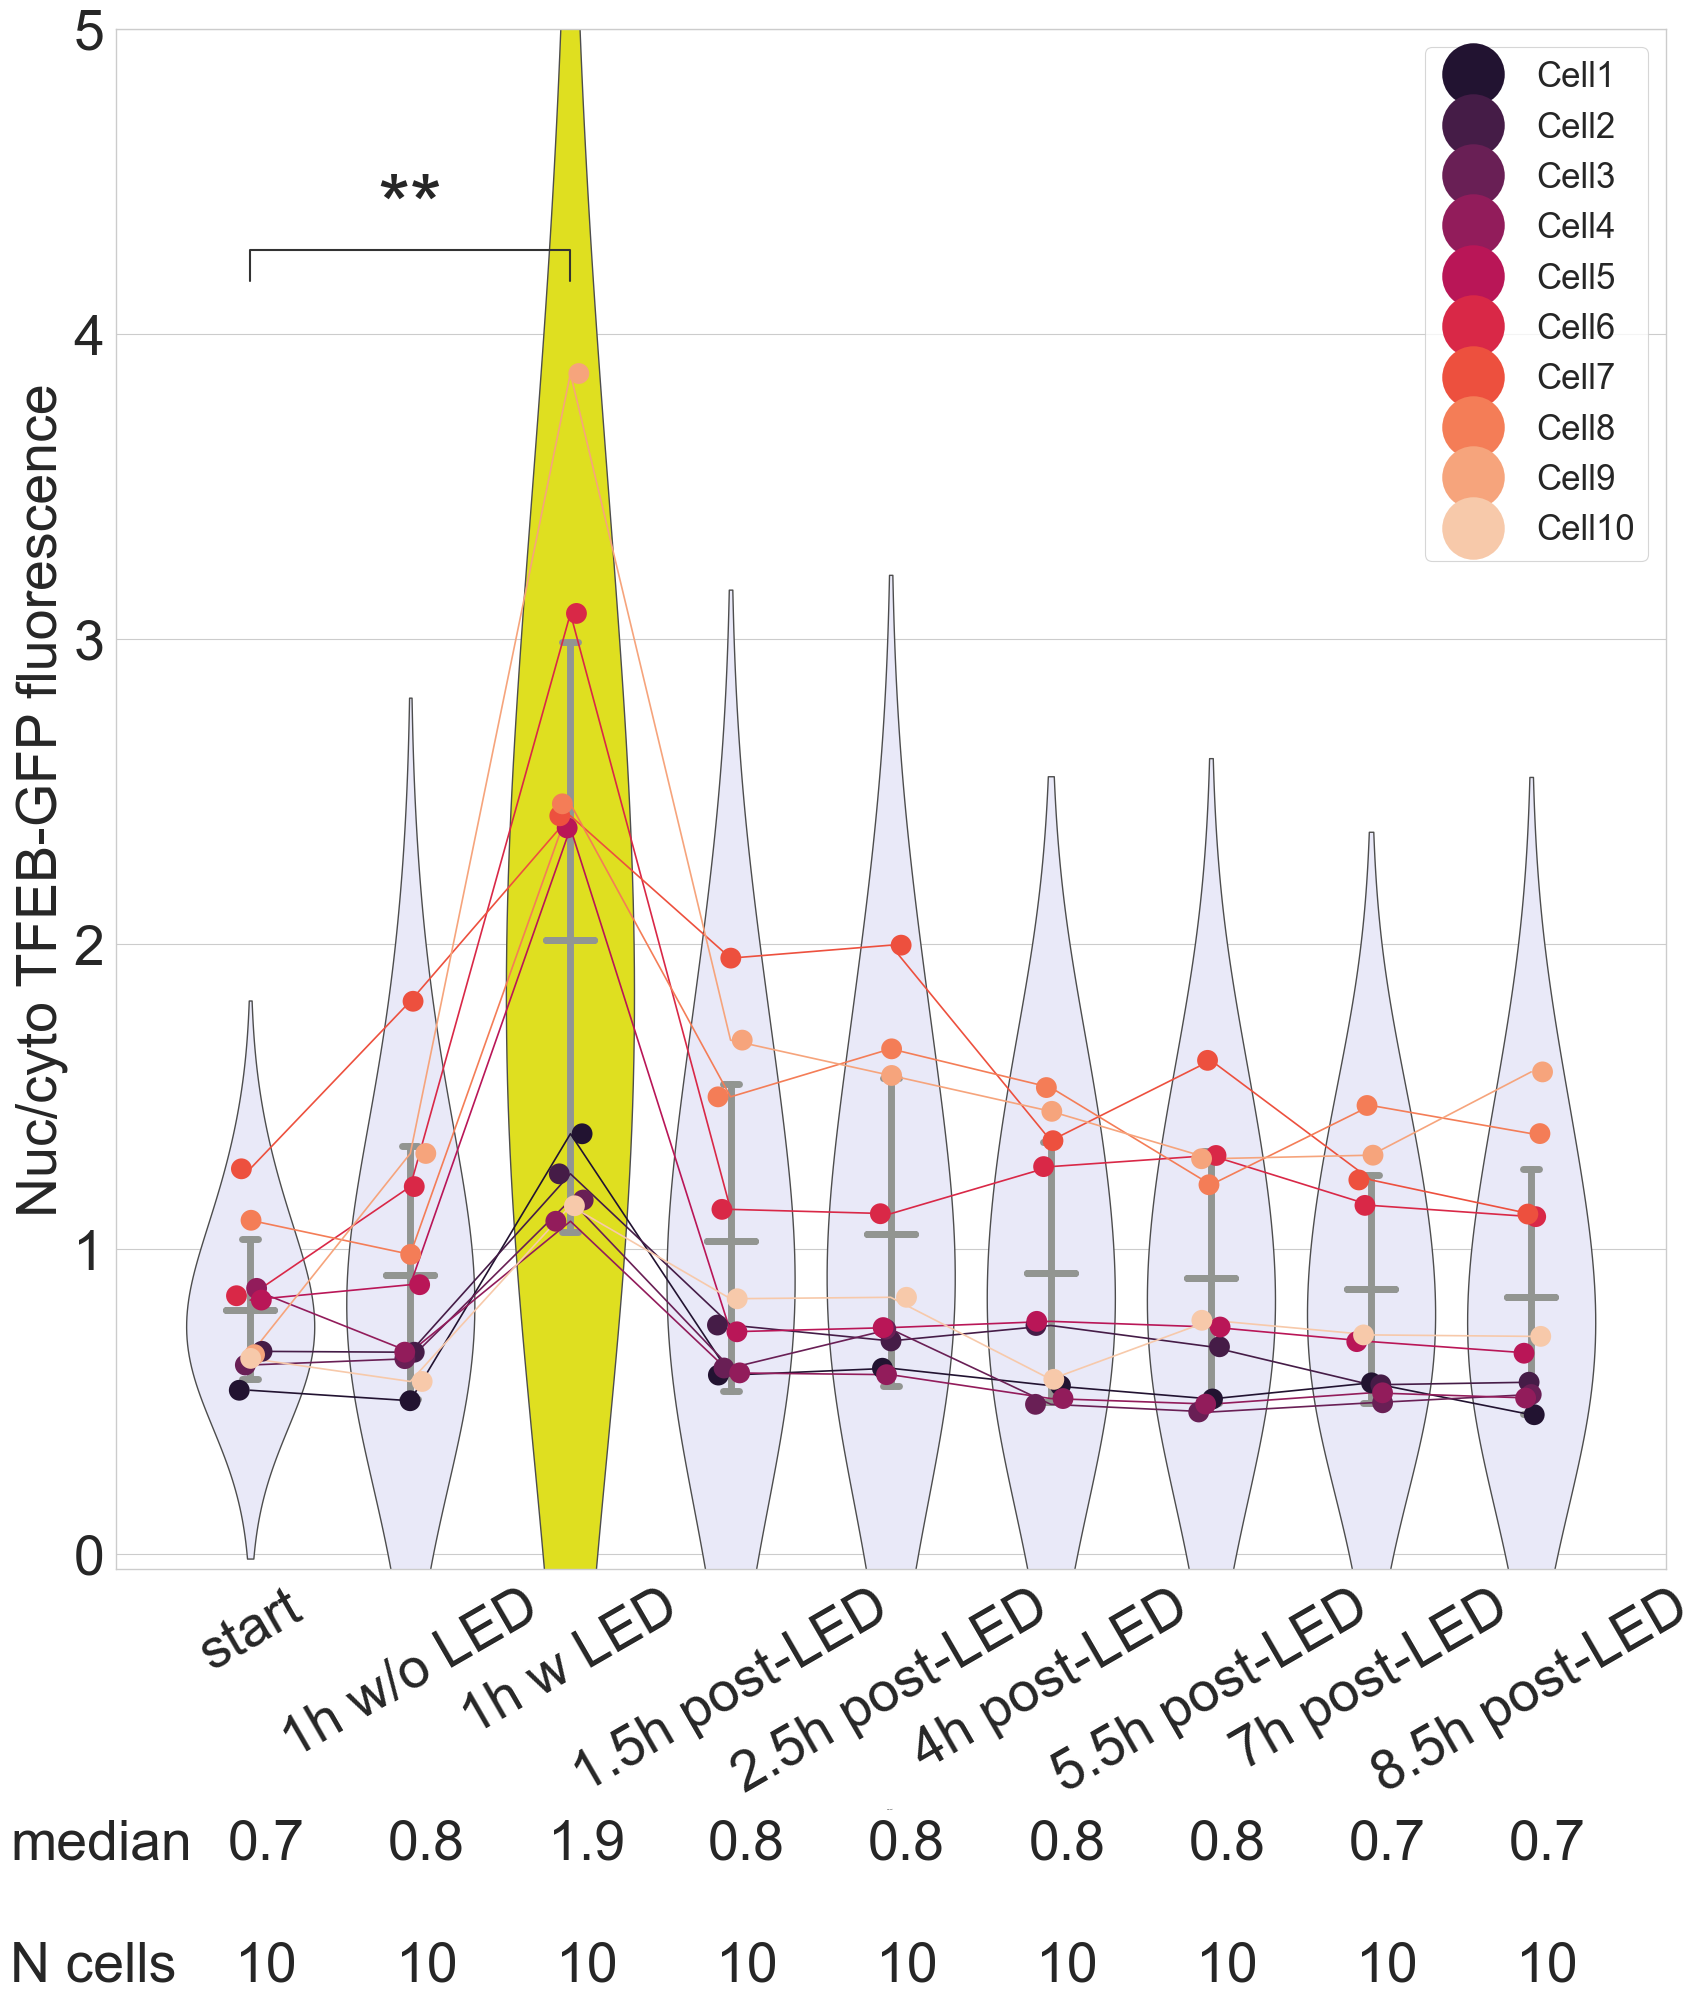

In [113]:
df_pmA3_TFEB = pd.read_excel('pmArch3-TFEB_Fiji.xlsx', sheet_name='20250320_res_assigned') #Nuc
make_a_graph_with_order(df_pmA3_TFEB, "Nuc/cyto TFEB-GFP fluorescence", 'Experiment', '','t-test_ind')
plt.savefig('pmArch3_TFEB_curr.jpg', bbox_inches = "tight", dpi=300) 